In [1]:
# Consolidated imports
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

from libpysal.weights import Queen, lag_spatial

from esda.moran import Moran

import statsmodels.api as sm
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV, RidgeCV

import warnings
warnings.filterwarnings('ignore')

%config InlineBackend.figure_format = 'retina'

# Spatial Feature Engineering Pipeline
This notebook demonstrates spatial feature engineering for San Francisco block groups. It loads cleaned data, computes a Queen weights graph, and evaluates four spatial feature types (coordinates, spatial lag, Moran eigenvectors, node2vec embeddings) in OLS regression, reporting fit and Moran's I of residuals for each.

## 1. Load Cleaned Dataset
Load tabular and spatial data, merge into a GeoDataFrame, and clean missing/infinite values.

In [2]:
# Load tabular and spatial data
data = pd.read_csv('data/incidents/InputDataset.csv', dtype={'BGFIPS10': object}).set_index('BGFIPS10')
geo = gpd.read_parquet('data/incidents/SF_BlockGroups10_Cleaned.parquet').set_index('BGFIPS10')
gdf = gpd.GeoDataFrame(data, geometry=geo.geometry)
gdf = gdf.replace([np.inf, -np.inf], np.nan).dropna()

## 2. Compute Queen Weights Graph
Build a Queen contiguity weights object (row-standardized) for use throughout the notebook.

In [3]:
# Compute Queen weights (row-standardized)
queen = Queen.from_dataframe(gdf, ids=gdf.index, silence_warnings=True)
queen.transform = "R"

## 3. Baseline OLS and Moran's I
Fit a simple OLS model (no spatial features) and compute Moran's I of residuals.

In [4]:
# Baseline OLS (no spatial features)
YVar = 'DrunkP1k'
XVars = ['pHHPov','BarPSqMi','RetailPSqMi','pMale','VacantHU']
y = gdf[YVar]
X = gdf[XVars]
X = sm.add_constant(X)
fit = sm.OLS(y, X).fit()
print(fit.summary())

                            OLS Regression Results                            
Dep. Variable:               DrunkP1k   R-squared:                       0.286
Model:                            OLS   Adj. R-squared:                  0.280
Method:                 Least Squares   F-statistic:                     45.79
Date:                Mon, 22 Sep 2025   Prob (F-statistic):           8.88e-40
Time:                        23:03:25   Log-Likelihood:                -2152.3
No. Observations:                 577   AIC:                             4317.
Df Residuals:                     571   BIC:                             4343.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const         -17.5017      3.062     -5.715      

In [5]:
# Compute residuals and Moran's I
residuals = y - fit.fittedvalues
moran_baseline = Moran(residuals.values, queen)
print('Baseline residual Moran I:', moran_baseline.I, moran_baseline.p_sim)

Baseline residual Moran I: 0.22244443850300277 0.001


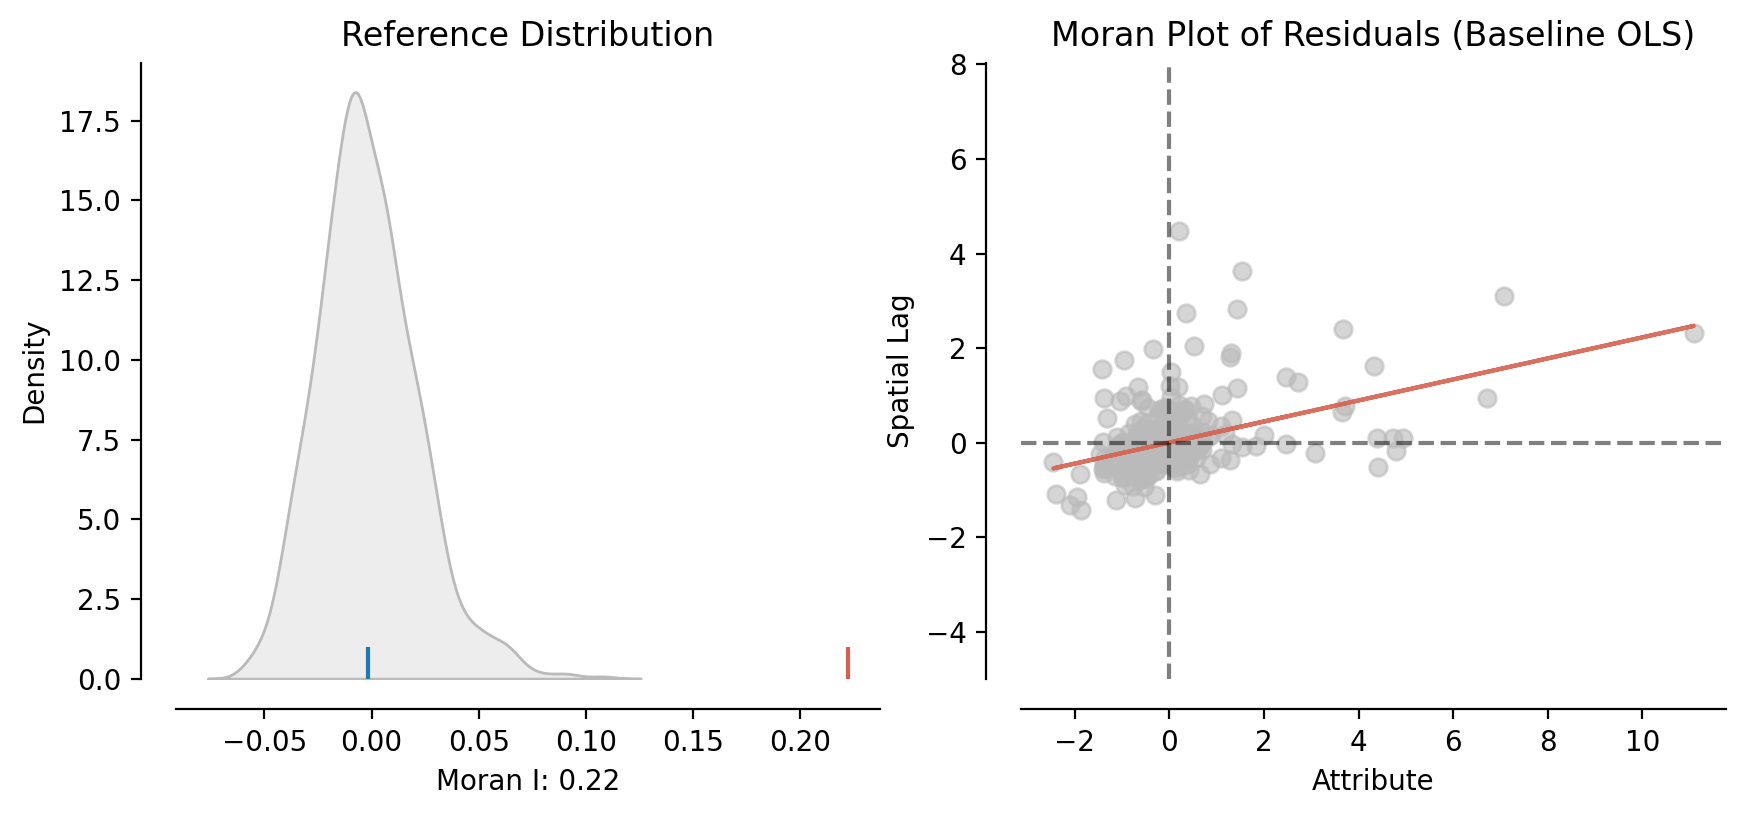

In [6]:
from splot.esda import plot_moran
plot_moran(moran_baseline, zstandard=True)
plt.title('Moran Plot of Residuals (Baseline OLS)')
plt.show()

## 4. Spatial Feature Engineering
We now compute and add each spatial feature class, then run OLS and Moran's I diagnostics for each.

### 4a. Coordinates
Add centroid coordinates as features and rerun OLS.

In [7]:
gdf['centroid_x'] = gdf.geometry.centroid.x
gdf['centroid_y'] = gdf.geometry.centroid.y
X_coord = sm.add_constant(gdf[XVars + ['centroid_x', 'centroid_y']])
fit_coord = sm.OLS(y, X_coord).fit()
print(fit_coord.summary())

                            OLS Regression Results                            
Dep. Variable:               DrunkP1k   R-squared:                       0.290
Model:                            OLS   Adj. R-squared:                  0.281
Method:                 Least Squares   F-statistic:                     33.23
Date:                Mon, 22 Sep 2025   Prob (F-statistic):           8.59e-39
Time:                        23:03:25   Log-Likelihood:                -2150.7
No. Observations:                 577   AIC:                             4317.
Df Residuals:                     569   BIC:                             4352.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          46.7414     36.768      1.271      

In [8]:
# Compute residuals and Moran's I for coordinates model
res_coord = y - fit_coord.fittedvalues
moran_coord = Moran(res_coord.values, queen)
print('Residual Moran I (coords):', moran_coord.I, moran_coord.p_sim)

Residual Moran I (coords): 0.22322033861061832 0.001


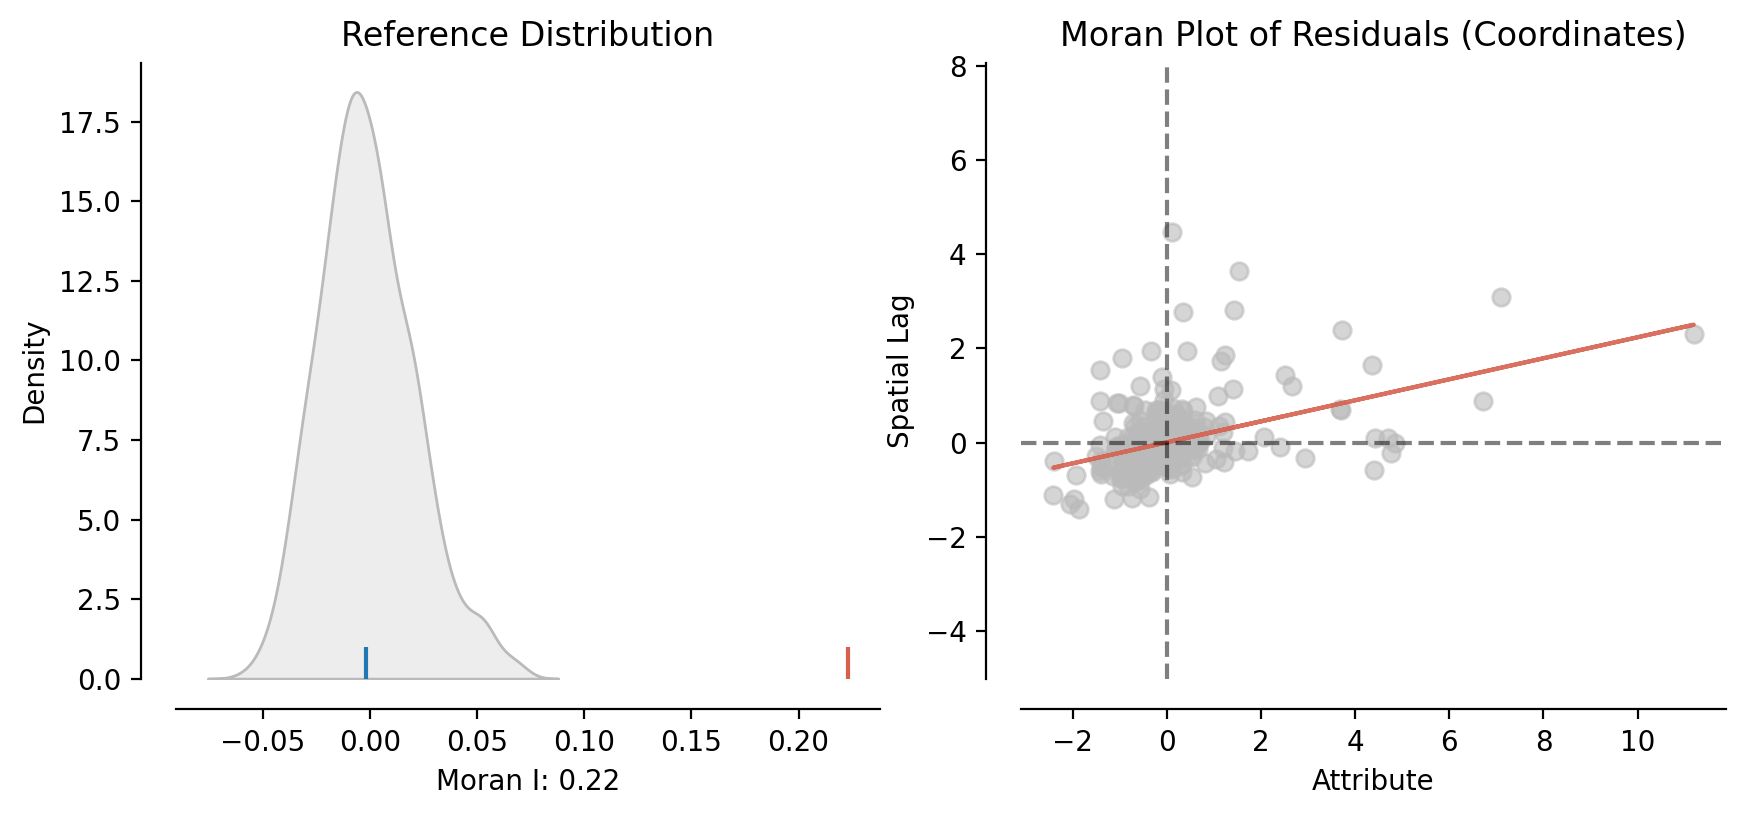

In [9]:
# Plot Moran's I of residuals for coordinates model
from splot.esda import plot_moran
plot_moran(Moran(res_coord.values, queen), zstandard=True)
plt.title('Moran Plot of Residuals (Coordinates)')
plt.show()

### 4b. Spatial Lag of Explanatory Variables
Add spatial lag features for each explanatory variable and rerun OLS.

In [10]:
def spatial_lag(df, columns, w):
    lagged = {}
    for col in columns:
        lagged[f"{col}_lag"] = lag_spatial(w, df[col].values)
    return pd.DataFrame(lagged, index=df.index)

# Compute spatial lags and add to gdf
gdf_lags = spatial_lag(gdf, XVars, queen)
for col in gdf_lags.columns:
    gdf[col] = gdf_lags[col]
X_lag = sm.add_constant(gdf[XVars + list(gdf_lags.columns)])
fit_lag = sm.OLS(y, X_lag).fit()
print(fit_lag.summary())

                            OLS Regression Results                            
Dep. Variable:               DrunkP1k   R-squared:                       0.328
Model:                            OLS   Adj. R-squared:                  0.317
Method:                 Least Squares   F-statistic:                     27.68
Date:                Mon, 22 Sep 2025   Prob (F-statistic):           3.86e-43
Time:                        23:03:26   Log-Likelihood:                -2134.7
No. Observations:                 577   AIC:                             4291.
Df Residuals:                     566   BIC:                             4339.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const             -34.5921      5.340     

In [11]:
# Compute residuals and Moran's I for spatial lag model
res_lag = y - fit_lag.fittedvalues
moran_lag = Moran(res_lag.values, queen)
print('Residual Moran I (spatial lag):', moran_lag.I, moran_lag.p_sim)

Residual Moran I (spatial lag): 0.19706339971695408 0.001


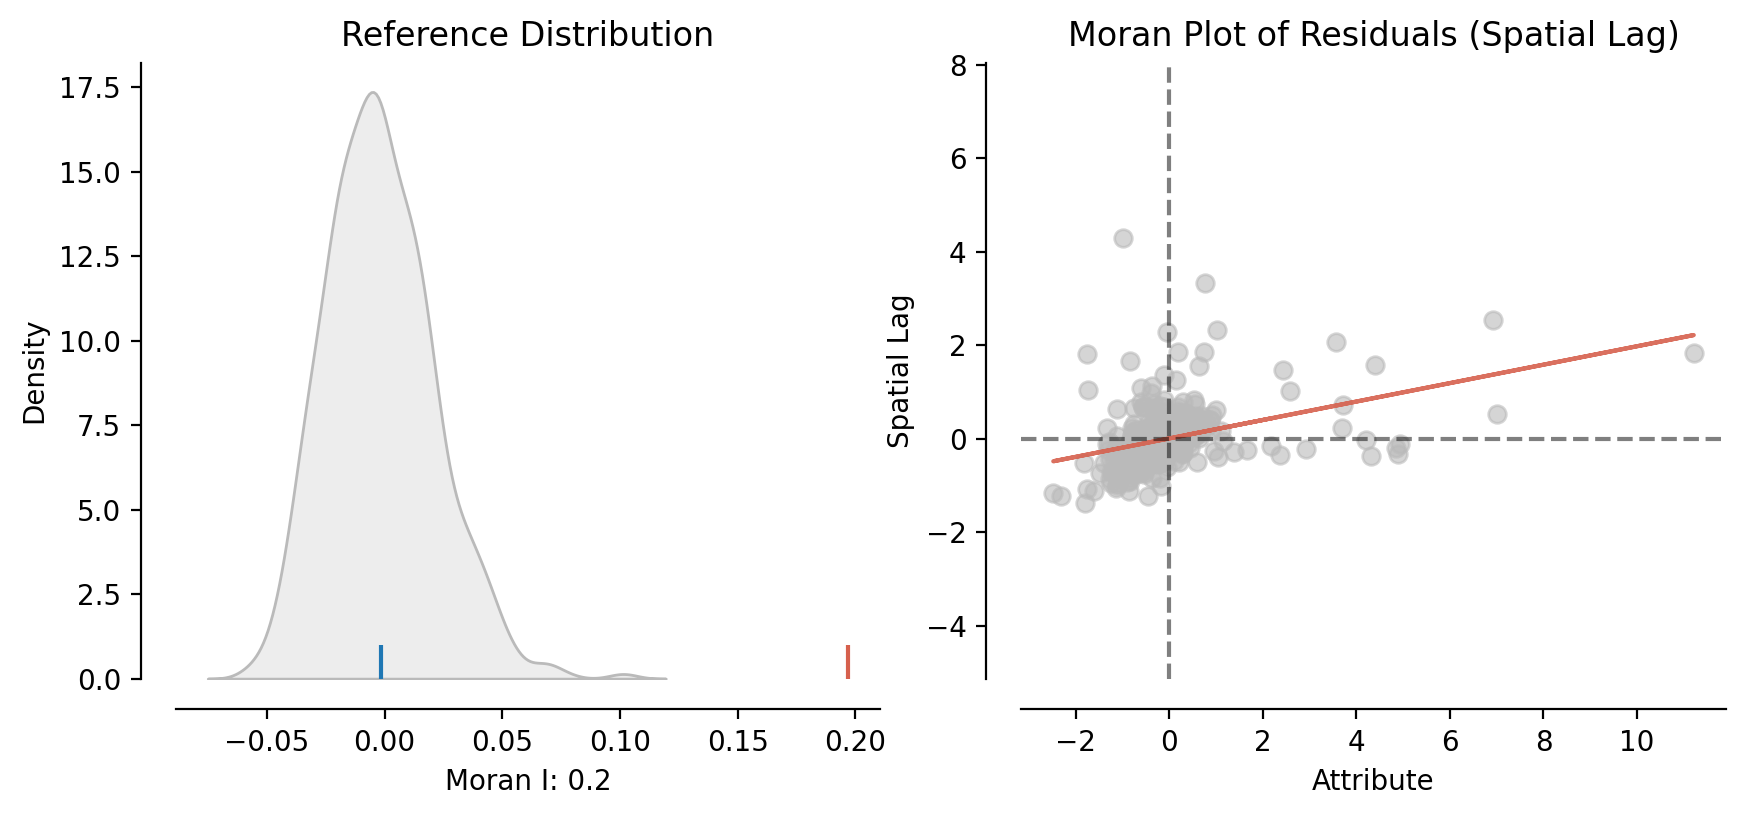

In [12]:
# Plot Moran's I of residuals for spatial lag model
plot_moran(Moran(res_lag.values, queen), zstandard=True)
plt.title('Moran Plot of Residuals (Spatial Lag)')
plt.show()

### 4c. Moran Eigenvector Spatial Filtering (MESF)
Compute Moran eigenvectors and add top k as features, then rerun OLS.

In [13]:
def compute_mesf(gdf, w, k=10):
    idx = gdf.index.to_list()
    n = len(idx)
    A = w.full()[0]
    I = np.eye(n)
    one = np.ones((n, 1))
    M = I - (one @ one.T) / n
    S = 0.5 * (M @ A @ M + M @ A.T @ M)
    evals, evecs = np.linalg.eigh(S)
    order = np.argsort(evals)[::-1]
    evals, evecs = evals[order], evecs[:, order]
    mem_cols = [f'MEM_{i}' for i in range(k)]
    mem_df = pd.DataFrame(evecs[:, :k], index=gdf.index, columns=mem_cols)
    return mem_df

# Compute MESF and add to gdf
mem_df = compute_mesf(gdf, queen, k=50)
for col in mem_df.columns:
    gdf[col] = mem_df[col]
X_mesf = sm.add_constant(gdf[XVars + list(mem_df.columns)])
fit_mesf = sm.OLS(y, X_mesf).fit()
print(fit_mesf.summary())

                            OLS Regression Results                            
Dep. Variable:               DrunkP1k   R-squared:                       0.478
Model:                            OLS   Adj. R-squared:                  0.423
Method:                 Least Squares   F-statistic:                     8.682
Date:                Mon, 22 Sep 2025   Prob (F-statistic):           1.78e-45
Time:                        23:03:26   Log-Likelihood:                -2061.9
No. Observations:                 577   AIC:                             4236.
Df Residuals:                     521   BIC:                             4480.
Df Model:                          55                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -8.9185      3.363     -2.652      

In [14]:
# Compute residuals and Moran's I for MESF model
res_mesf = y - fit_mesf.fittedvalues
moran_mesf = Moran(res_mesf.values, queen)
print('Residual Moran I (MESF):', moran_mesf.I, moran_mesf.p_sim)

Residual Moran I (MESF): 0.016701353101938567 0.18


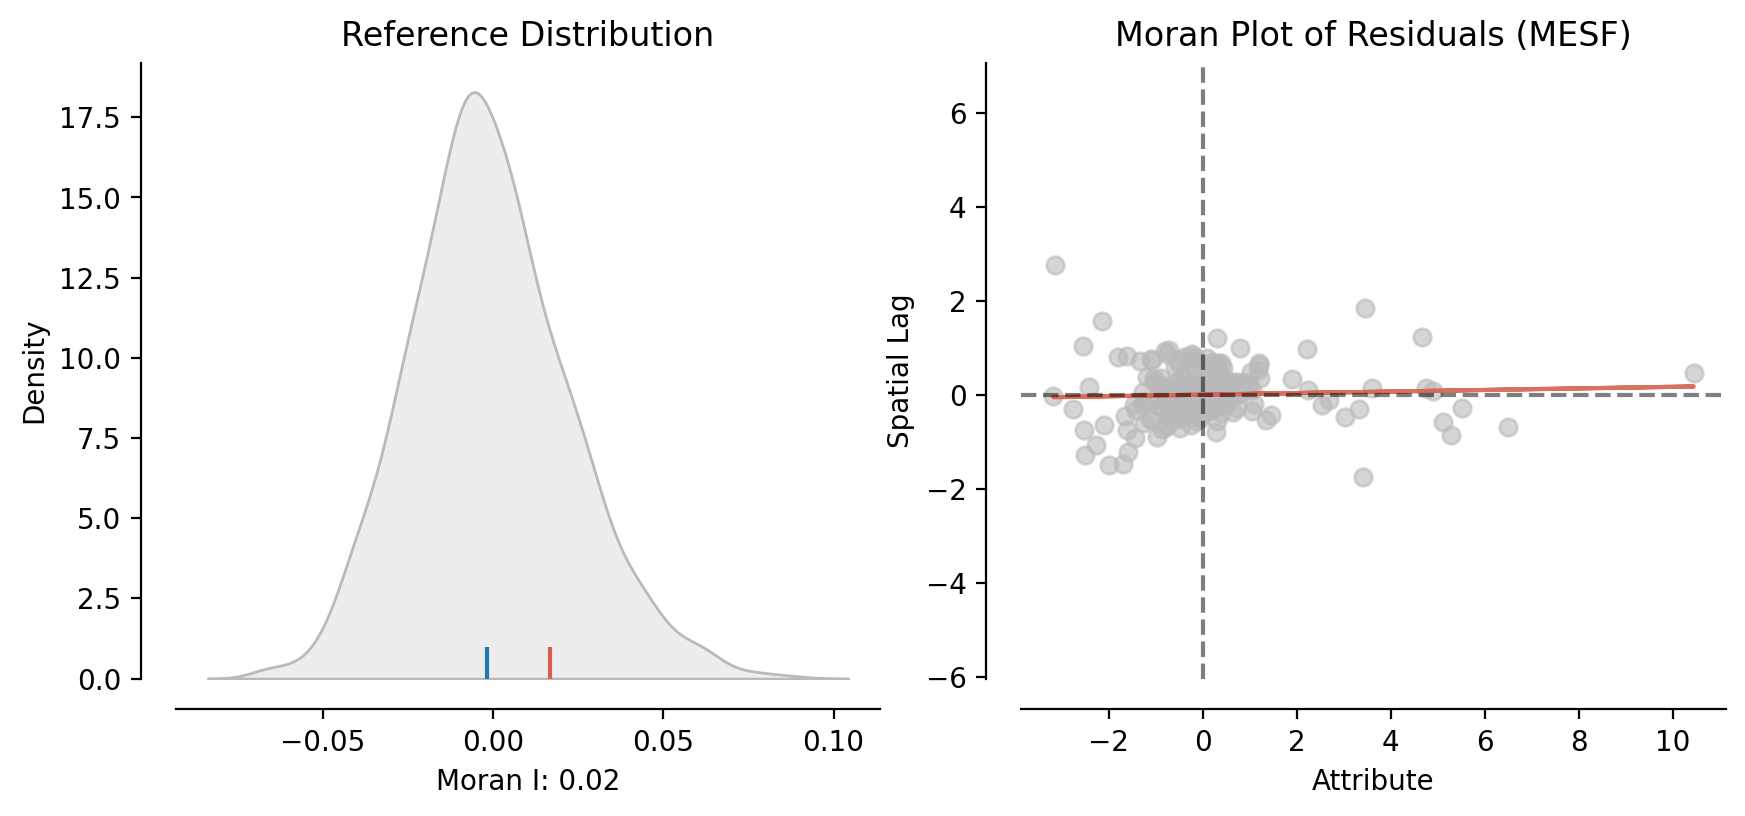

In [15]:
# Plot Moran's I of residuals for MESF model
plot_moran(Moran(res_mesf.values, queen), zstandard=True)
plt.title('Moran Plot of Residuals (MESF)')
plt.show()

### 4d. Graph Embeddings with PyTorch Geometric GCN
In this section, we use a GCN autoencoder to generate spatial graph embeddings for each block group. We first define the model, then perform a grid search to select the optimal embedding size, and finally run the optimized model to generate features for OLS regression.

#### Step 1: Define the GCN Autoencoder Model
We first define the GCN autoencoder architecture, which will be used to learn node embeddings from the Queen contiguity graph and explanatory variables.

In [16]:
# Prepare node features: explanatory variables only
scaler = StandardScaler()
X_feats = scaler.fit_transform(gdf[XVars])
x = torch.tensor(X_feats, dtype=torch.float32)

# Graph structure from Queen weights
G_nx = queen.to_networkx()
edge_index = torch.tensor(list(G_nx.edges)).t().contiguous()

# Define GCN autoencoder model
class GCN_AE(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels):
        super().__init__()
        self.encoder = GCNConv(in_channels, hidden_channels)
        self.decoder = torch.nn.Linear(hidden_channels, in_channels)
    def forward(self, x, edge_index):
        z = F.relu(self.encoder(x, edge_index))
        x_hat = self.decoder(z)
        return x_hat, z

#### Step 2: Grid Search for Optimal Embedding Size
We perform a grid search over several candidate embedding sizes (e.g., 4, 8, 16, 32, 48, 64, 128). For each size, we train the autoencoder, use the embeddings as features in OLS, and record model fit (AIC) and residual spatial autocorrelation (Moran's I and p-value).

In [17]:
# Grid search for best embedding size
dims = [4, 8, 16, 32, 48, 64, 128]
results = []

for dim in dims:
    # Train GCN autoencoder with 'dim' hidden units
    model = GCN_AE(x.shape[1], dim)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    for epoch in range(200):
        model.train()
        optimizer.zero_grad()
        x_hat, z = model(x, edge_index)
        loss = F.mse_loss(x_hat, x)
        loss.backward()
        optimizer.step()
    embeddings = z.detach().numpy()
    for i in range(embeddings.shape[1]):
        gdf[f'gcn_ae_embed_{i}'] = embeddings[:, i]
    X_gcn_ae = sm.add_constant(gdf[XVars + [f'gcn_ae_embed_{i}' for i in range(embeddings.shape[1])]])
    fit_gcn_ae = sm.OLS(y, X_gcn_ae).fit()
    print(f'Embedding dim {dim} OLS summary:')
    print(fit_gcn_ae.summary())

Embedding dim 4 OLS summary:
                            OLS Regression Results                            
Dep. Variable:               DrunkP1k   R-squared:                       0.314
Model:                            OLS   Adj. R-squared:                  0.303
Method:                 Least Squares   F-statistic:                     28.78
Date:                Mon, 22 Sep 2025   Prob (F-statistic):           2.85e-41
Time:                        23:03:26   Log-Likelihood:                -2141.1
No. Observations:                 577   AIC:                             4302.
Df Residuals:                     567   BIC:                             4346.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const          

In [18]:
res_gcn_ae = y - fit_gcn_ae.fittedvalues
moran_I = Moran(res_gcn_ae.values, queen)
aic = fit_gcn_ae.aic
print(f'Embedding dim {dim}: AIC={aic:.2f}, Moran I={moran_I.I:.4f}, p-value={moran_I.p_sim:.4f}')

Embedding dim 128: AIC=4078.27, Moran I=-0.0369, p-value=0.0690


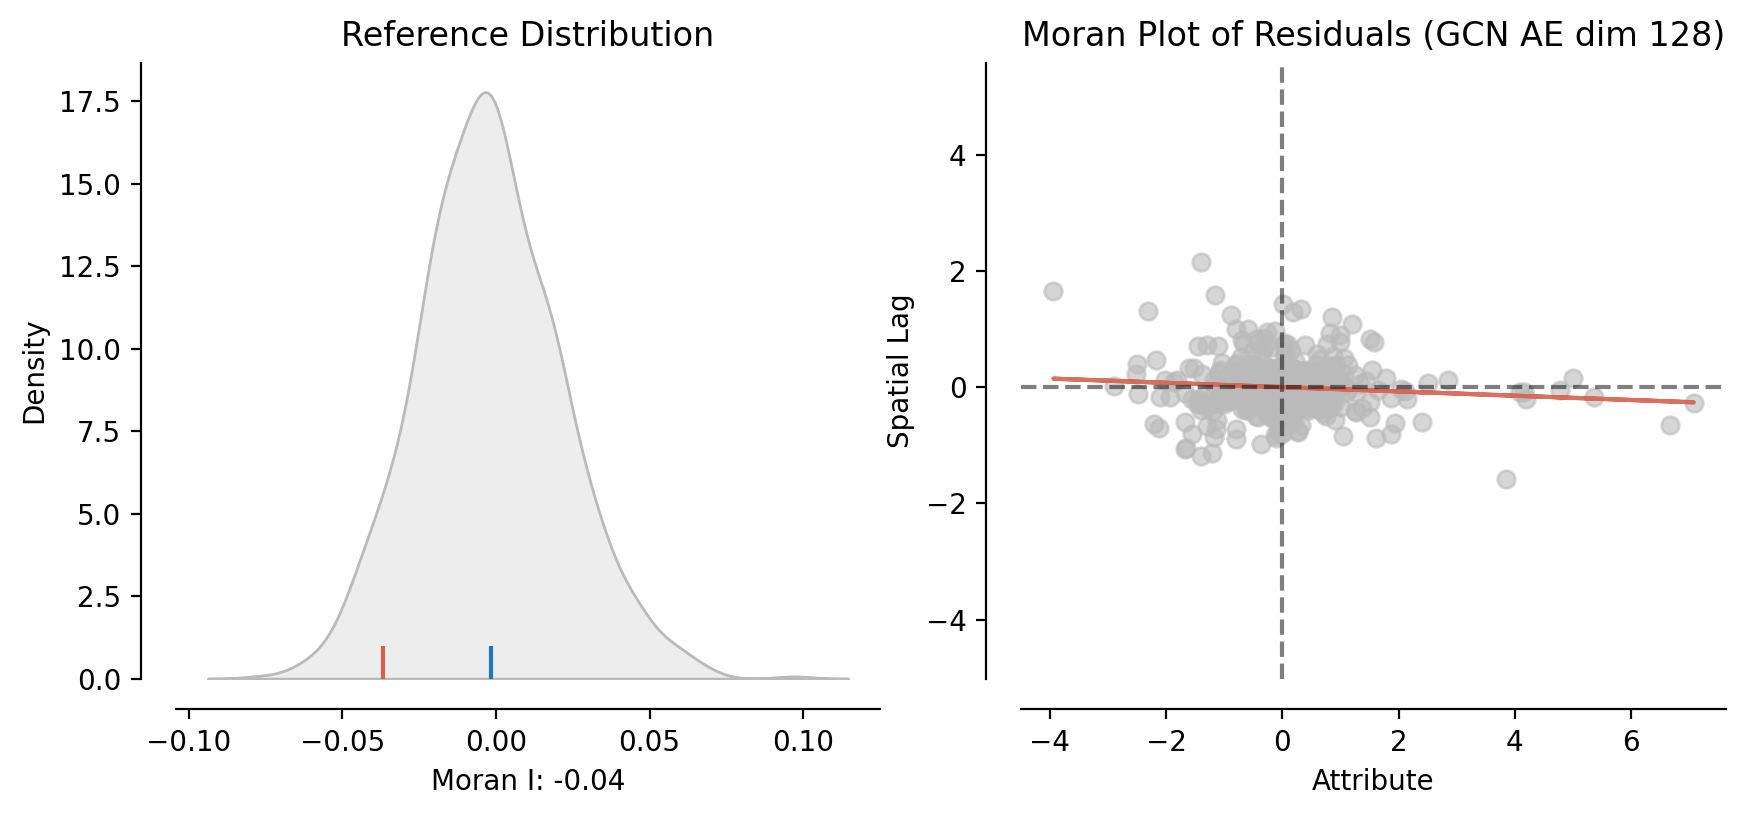

In [19]:
plot_moran(Moran(res_gcn_ae.values, queen), zstandard=True)
plt.title(f'Moran Plot of Residuals (GCN AE dim {dim})')
plt.show()

#### Step 3: Run Final Optimized Model
After selecting the best embedding size (lowest residual Moran's I and competitive AIC), we retrain the GCN autoencoder with this size and use the resulting embeddings as features in the final OLS regression.

In [20]:
# Final model: set best_dim to the optimal embedding size found above (e.g., best_dim = 48)
best_dim = 48  # Replace with your selected value from grid search
model = GCN_AE(x.shape[1], best_dim)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
for epoch in range(200):
    model.train()
    optimizer.zero_grad()
    x_hat, z = model(x, edge_index)
    loss = F.mse_loss(x_hat, x)
    loss.backward()
    optimizer.step()
embeddings = z.detach().numpy()
for i in range(embeddings.shape[1]):
    gdf[f'gcn_ae_embed_{i}'] = embeddings[:, i]
X_gcn_ae = sm.add_constant(gdf[XVars + [f'gcn_ae_embed_{i}' for i in range(embeddings.shape[1])]])
fit_gcn_ae = sm.OLS(y, X_gcn_ae).fit()
print(fit_gcn_ae.summary())

                            OLS Regression Results                            
Dep. Variable:               DrunkP1k   R-squared:                       0.506
Model:                            OLS   Adj. R-squared:                  0.456
Method:                 Least Squares   F-statistic:                     10.09
Date:                Mon, 22 Sep 2025   Prob (F-statistic):           6.05e-52
Time:                        23:03:28   Log-Likelihood:                -2046.4
No. Observations:                 577   AIC:                             4201.
Df Residuals:                     523   BIC:                             4436.
Df Model:                          53                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               3.4713     12.966     

In [21]:
# Compute residuals and Moran's I for final GCN AE model
res_gcn_ae = y - fit_gcn_ae.fittedvalues
moran = Moran(res_gcn_ae.values, queen)
print(f'Residual Moran I (final GCN AE): {moran.I:.4f}, p-value: {moran.p_sim:.4f}')

Residual Moran I (final GCN AE): 0.0067, p-value: 0.3210


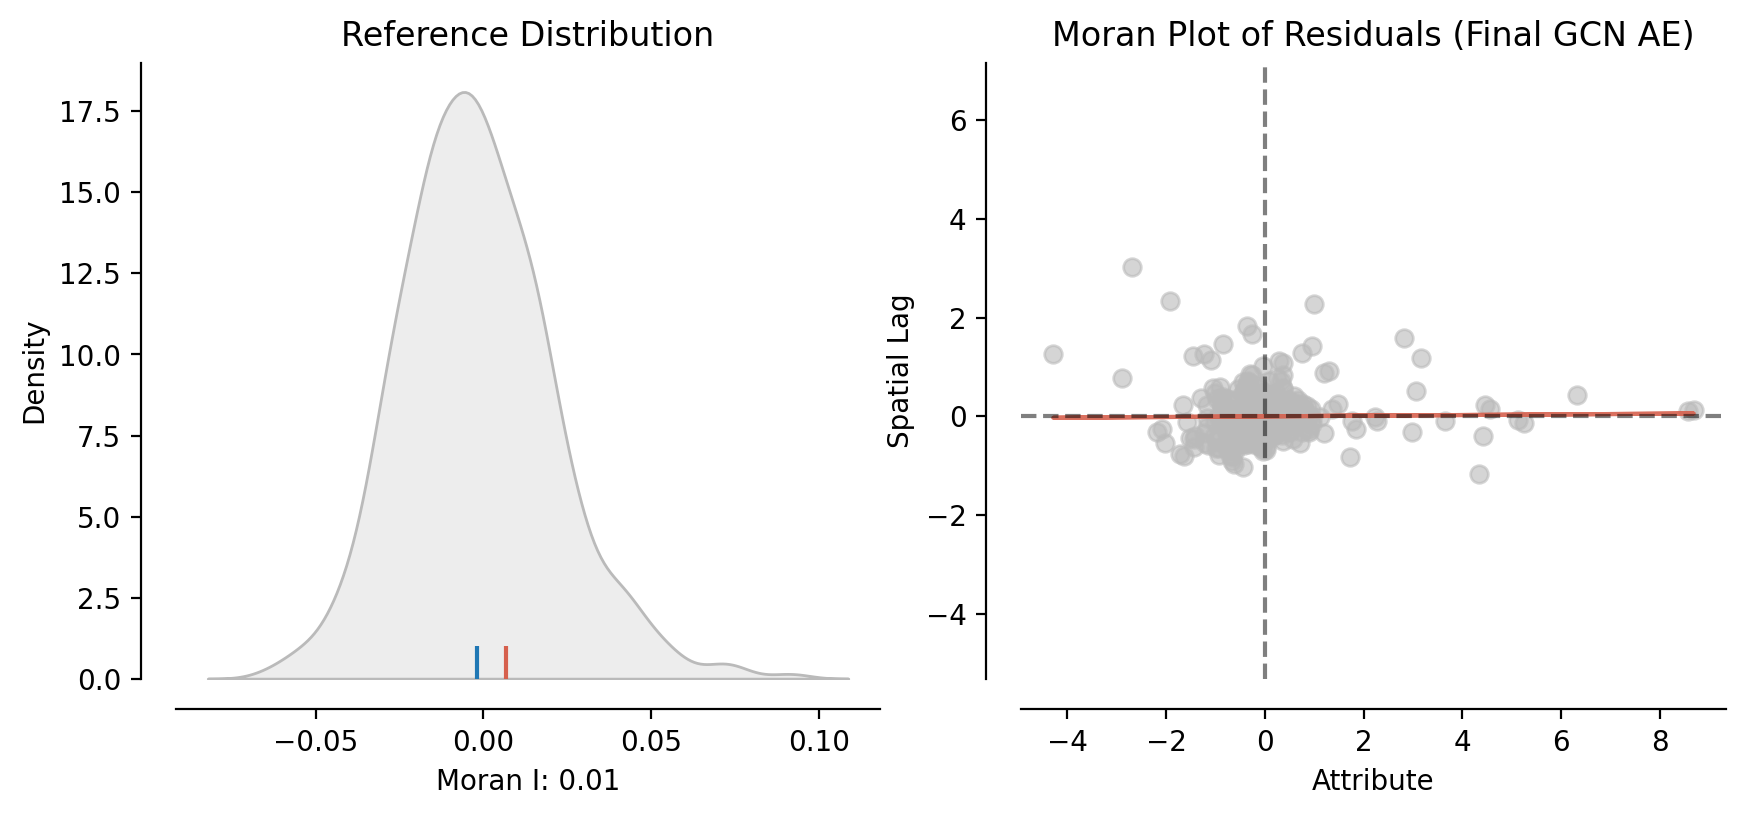

In [22]:
# Plot Moran's I of residuals for final GCN AE model
plot_moran(Moran(res_gcn_ae.values, queen), zstandard=True)
plt.title('Moran Plot of Residuals (Final GCN AE)')
plt.show()

# Model Comparison and Summary
In this section, we compare all fitted models (including baseline, spatial features, and VIF-selected models) using AIC and Moran's I of residuals.

In [23]:
# Summary of fit metrics and Moran's I for all models (R_squared, R_squared_adjusted, and AIC)
summary_rows = []

try:
    summary_rows.append({
        'Model': 'Baseline OLS',
        'R_squared': fit.rsquared,
        'R_squared_adj': fit.rsquared_adj,
        'AIC': fit.aic,
        'Moran I': moran_baseline.I,
        'p-value': moran_baseline.p_sim
    })
except Exception:
    pass

try:
    summary_rows.append({
        'Model': 'Coordinates',
        'R_squared': fit_coord.rsquared,
        'R_squared_adj': fit_coord.rsquared_adj,
        'AIC': fit_coord.aic,
        'Moran I': moran_coord.I,
        'p-value': moran_coord.p_sim
    })
except Exception:
    pass

try:
    summary_rows.append({
        'Model': 'Spatial Lag',
        'R_squared': fit_lag.rsquared,
        'R_squared_adj': fit_lag.rsquared_adj,
        'AIC': fit_lag.aic,
        'Moran I': moran_lag.I,
        'p-value': moran_lag.p_sim
    })
except Exception:
    pass

try:
    summary_rows.append({
        'Model': 'MESF',
        'R_squared': fit_mesf.rsquared,
        'R_squared_adj': fit_mesf.rsquared_adj,
        'AIC': fit_mesf.aic,
        'Moran I': moran_mesf.I,
        'p-value': moran_mesf.p_sim
    })
except Exception:
    pass

try:
    summary_rows.append({
        'Model': 'GCN AE',
        'R_squared': fit_gcn_ae.rsquared,
        'R_squared_adj': fit_gcn_ae.rsquared_adj,
        'AIC': fit_gcn_ae.aic,
        'Moran I': moran.I,
        'p-value': moran.p_sim
    })
except Exception:
    pass

summary = pd.DataFrame(summary_rows)
print(summary)


          Model  R_squared  R_squared_adj          AIC   Moran I  p-value
0  Baseline OLS   0.286206       0.279956  4316.672765  0.222444    0.001
1   Coordinates   0.290205       0.281472  4317.431778  0.223220    0.001
2   Spatial Lag   0.328436       0.316571  4291.485016  0.197063    0.001
3          MESF   0.478230       0.423149  4235.859643  0.016701    0.180
4        GCN AE   0.505614       0.455514  4200.753676  0.006657    0.321
